In [156]:
import pandas as pd
import torch
from darts import TimeSeries
from darts.models import TiDEModel
from darts.metrics import mae, rmse, mape
import matplotlib.pyplot as plt

In [157]:
# Đọc dữ liệu từ file CSV và đảo ngược dữ liệu
data = pd.read_csv('halong_quality.csv')

In [158]:
# Tạo cột index mới là số thứ tự của dòng bắt đầu từ 0
data['index'] = data.index

In [159]:
smo = data['pm25']

In [160]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    series_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    series_smoothed_interpolated = series_smoothed.interpolate()

    # Fill remaining NaN values
    series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)
    
    return series_smoothed_filled

In [161]:
smo = smoothed(smo)

C:\Users\21521\AppData\Local\Temp\ipykernel_13476\3312313537.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)


In [162]:
data['pm25'] = smo

In [163]:
# Chuyển đổi DataFrame thành TimeSeries của Darts
series = TimeSeries.from_dataframe(data, 'index', 'pm25')

In [164]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 70:30
train, test = series.split_after(0.7)


In [165]:
# Thiết lập tham số cho mô hình
optimizer_kwargs = {
    "lr": 1e-3,
}

pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
}

lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

common_model_args = {
    "input_chunk_length": 90,
    "output_chunk_length": 30,
    "optimizer_cls": torch.optim.Adam,  # Sử dụng Adam optimizer
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}


In [166]:
# Tạo và huấn luyện mô hình TiDE
model_tide = TiDEModel(
    **common_model_args, use_reversible_instance_norm=False, model_name="tide"
)

model_tide.fit(series=train, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=90, output_chunk_length=30, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto'}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=None, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42, use_reversible_instance_norm=False, model_name=tide)

In [167]:
# Dự đoán và đánh giá mô hình
pred_steps = len(test)
pred_input = train
# Dự đoán
pred_series = model_tide.predict(n=pred_steps, series=pred_input)
# Dự đoán 90 ngày tiếp theo
last_index = data.index[-1]
future = TimeSeries.from_dataframe(pd.DataFrame({'index': range(last_index + 1, last_index + 91)}), 'index')
pred_future = model_tide.predict(n=90, series=series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


In [168]:
pred = pred_series.pd_dataframe()

In [169]:
pred = smoothed(pred)

C:\Users\21521\AppData\Local\Temp\ipykernel_13476\3312313537.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)


In [170]:
pred = TimeSeries.from_dataframe(pred, None, 'pm25')

In [171]:
# Tách dữ liệu dự đoán thành 3 phần
pred_future_1_30 = pred_future[:30]
pred_future_31_60 = pred_future[30:60]
pred_future_61_90 = pred_future[60:]

In [172]:
# Tính toán các chỉ số lỗi
mae_value = mae(test, pred)
rmse_value = rmse(test, pred)
mape_value = mape(test, pred)

# Hiển thị kết quả
print(f"MAE: {mae_value}")
print(f"RMSE: {rmse_value}")
print(f"MAPE: {mape_value}")

MAE: 9.669239125424431
RMSE: 12.666064797960733
MAPE: 26.329939424532736


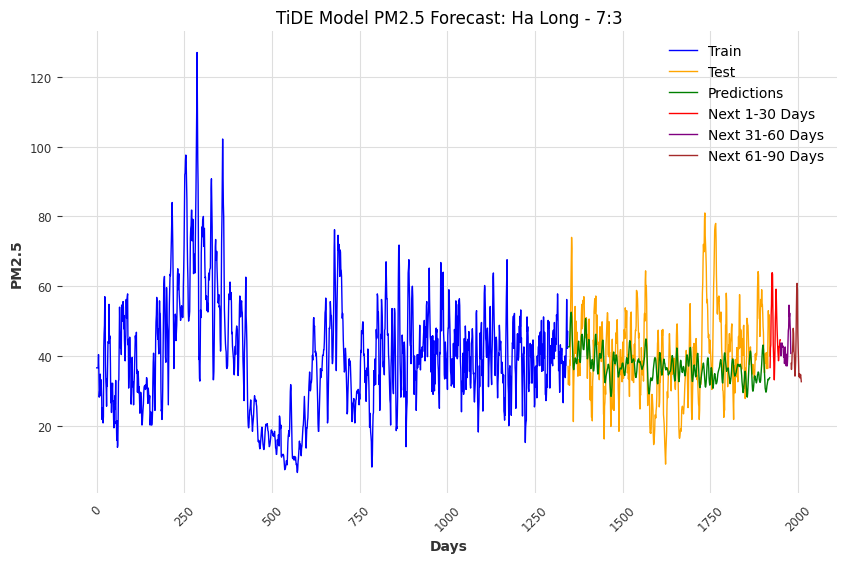

In [173]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ tập huấn luyện
train.plot(label='Train', ax=ax, lw=1, color='blue')

# Vẽ tập kiểm tra
test.plot(label='Test', ax=ax, lw=1, color='orange')

# Vẽ giá trị dự đoán
pred.plot(label='Predictions', ax=ax, lw=1, color='green')

# Vẽ giá trị dự đoán cho 90 ngày tiếp theo với 3 màu khác nhau
pred_future_1_30.plot(label='Next 1-30 Days', ax=ax, lw=1, color='red')
pred_future_31_60.plot(label='Next 31-60 Days', ax=ax, lw=1, color='purple')
pred_future_61_90.plot(label='Next 61-90 Days', ax=ax, lw=1, color='brown')

# Đặt nhãn cho trục x là các index
ax.set_xlabel("Days")
ax.set_ylabel("PM2.5")
ax.legend()

# Hiển thị các nhãn index trên trục x cho dễ đọc
plt.xticks(rotation=45)
plt.title('TiDE Model PM2.5 Forecast: Ha Long - 7:3')
plt.show()

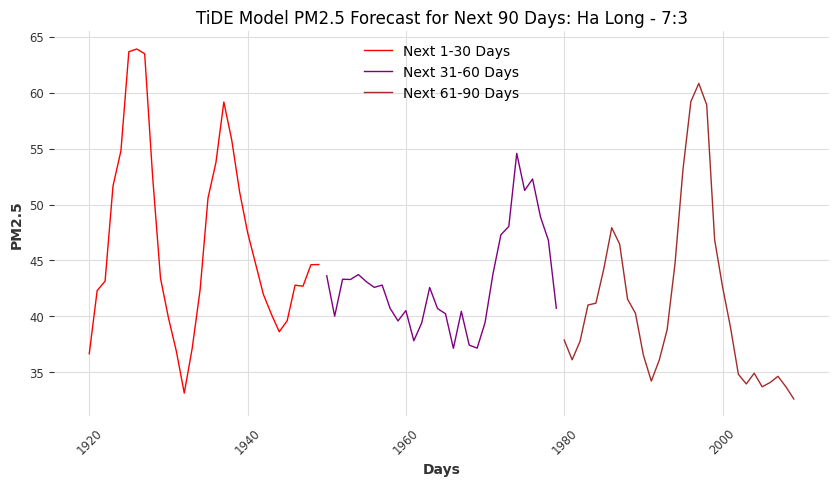

In [174]:
# Vẽ biểu đồ dự đoán 90 ngày tiếp theo
fig, ax = plt.subplots(figsize=(10, 5))

# Vẽ giá trị dự đoán cho 90 ngày tiếp theo với 3 màu khác nhau
pred_future_1_30.plot(label='Next 1-30 Days', ax=ax, lw=1, color='red')
pred_future_31_60.plot(label='Next 31-60 Days', ax=ax, lw=1, color='purple')
pred_future_61_90.plot(label='Next 61-90 Days', ax=ax, lw=1, color='brown')

ax.set_xlabel("Days")
ax.set_ylabel("PM2.5")
ax.legend()

plt.xticks(rotation=45)
plt.title('TiDE Model PM2.5 Forecast for Next 90 Days: Ha Long - 7:3')
plt.show()